In [1]:
# !pip install plotly greykite



from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import plotly
import prophet

from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam


TypeError: This is a python-holidays entity loader class. For entity inheritance purposes please import a class you want to derive from directly: e.g., `from holidays.countries import Entity` or `from holidays.financial import Entity`.

In [ ]:
df = pd.read_csv(
    "GBPJPY.csv",
    parse_dates=[['<DTYYYYMMDD>','<TIME>']]).set_index('<DTYYYYMMDD>_<TIME>'
    )
df = df.loc['2023-04-01':].resample('4H').mean().dropna()
df.reset_index(inplace=True)
df = df[['<DTYYYYMMDD>_<TIME>','<CLOSE>']]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


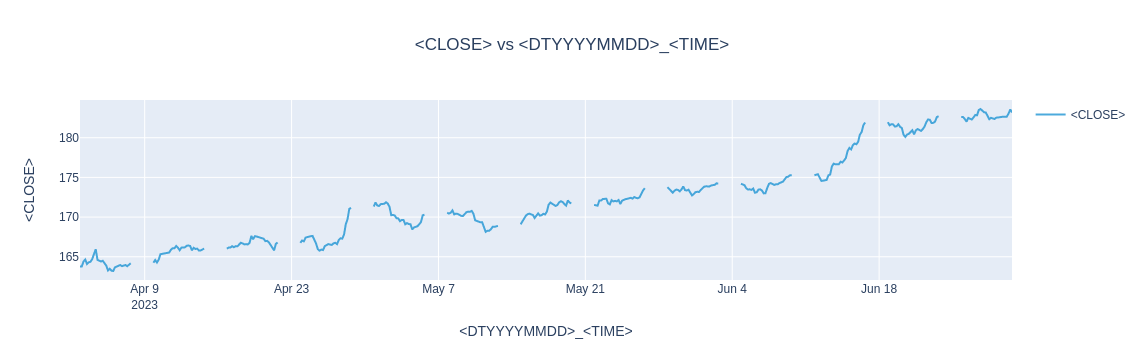

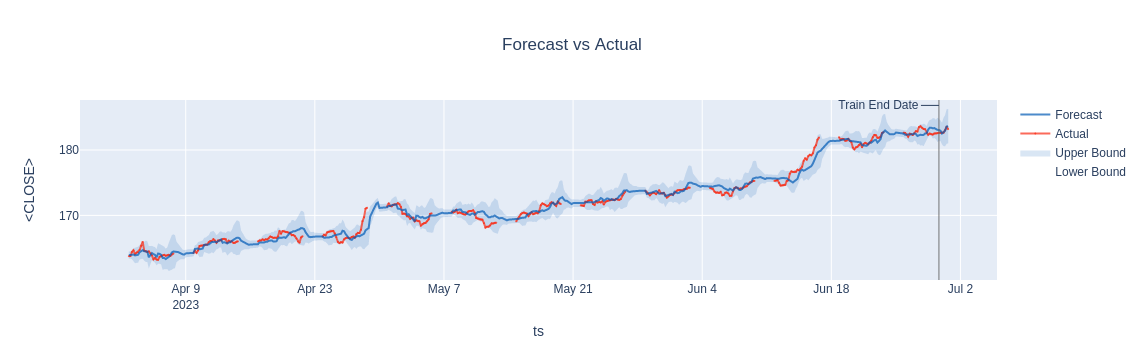

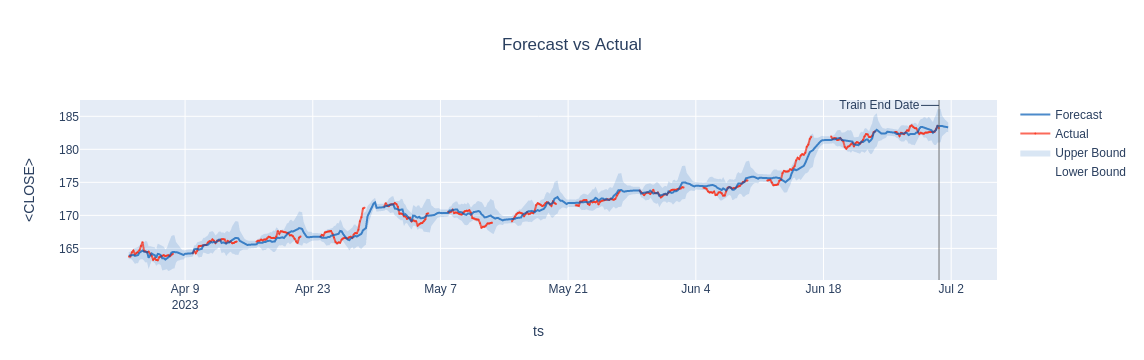

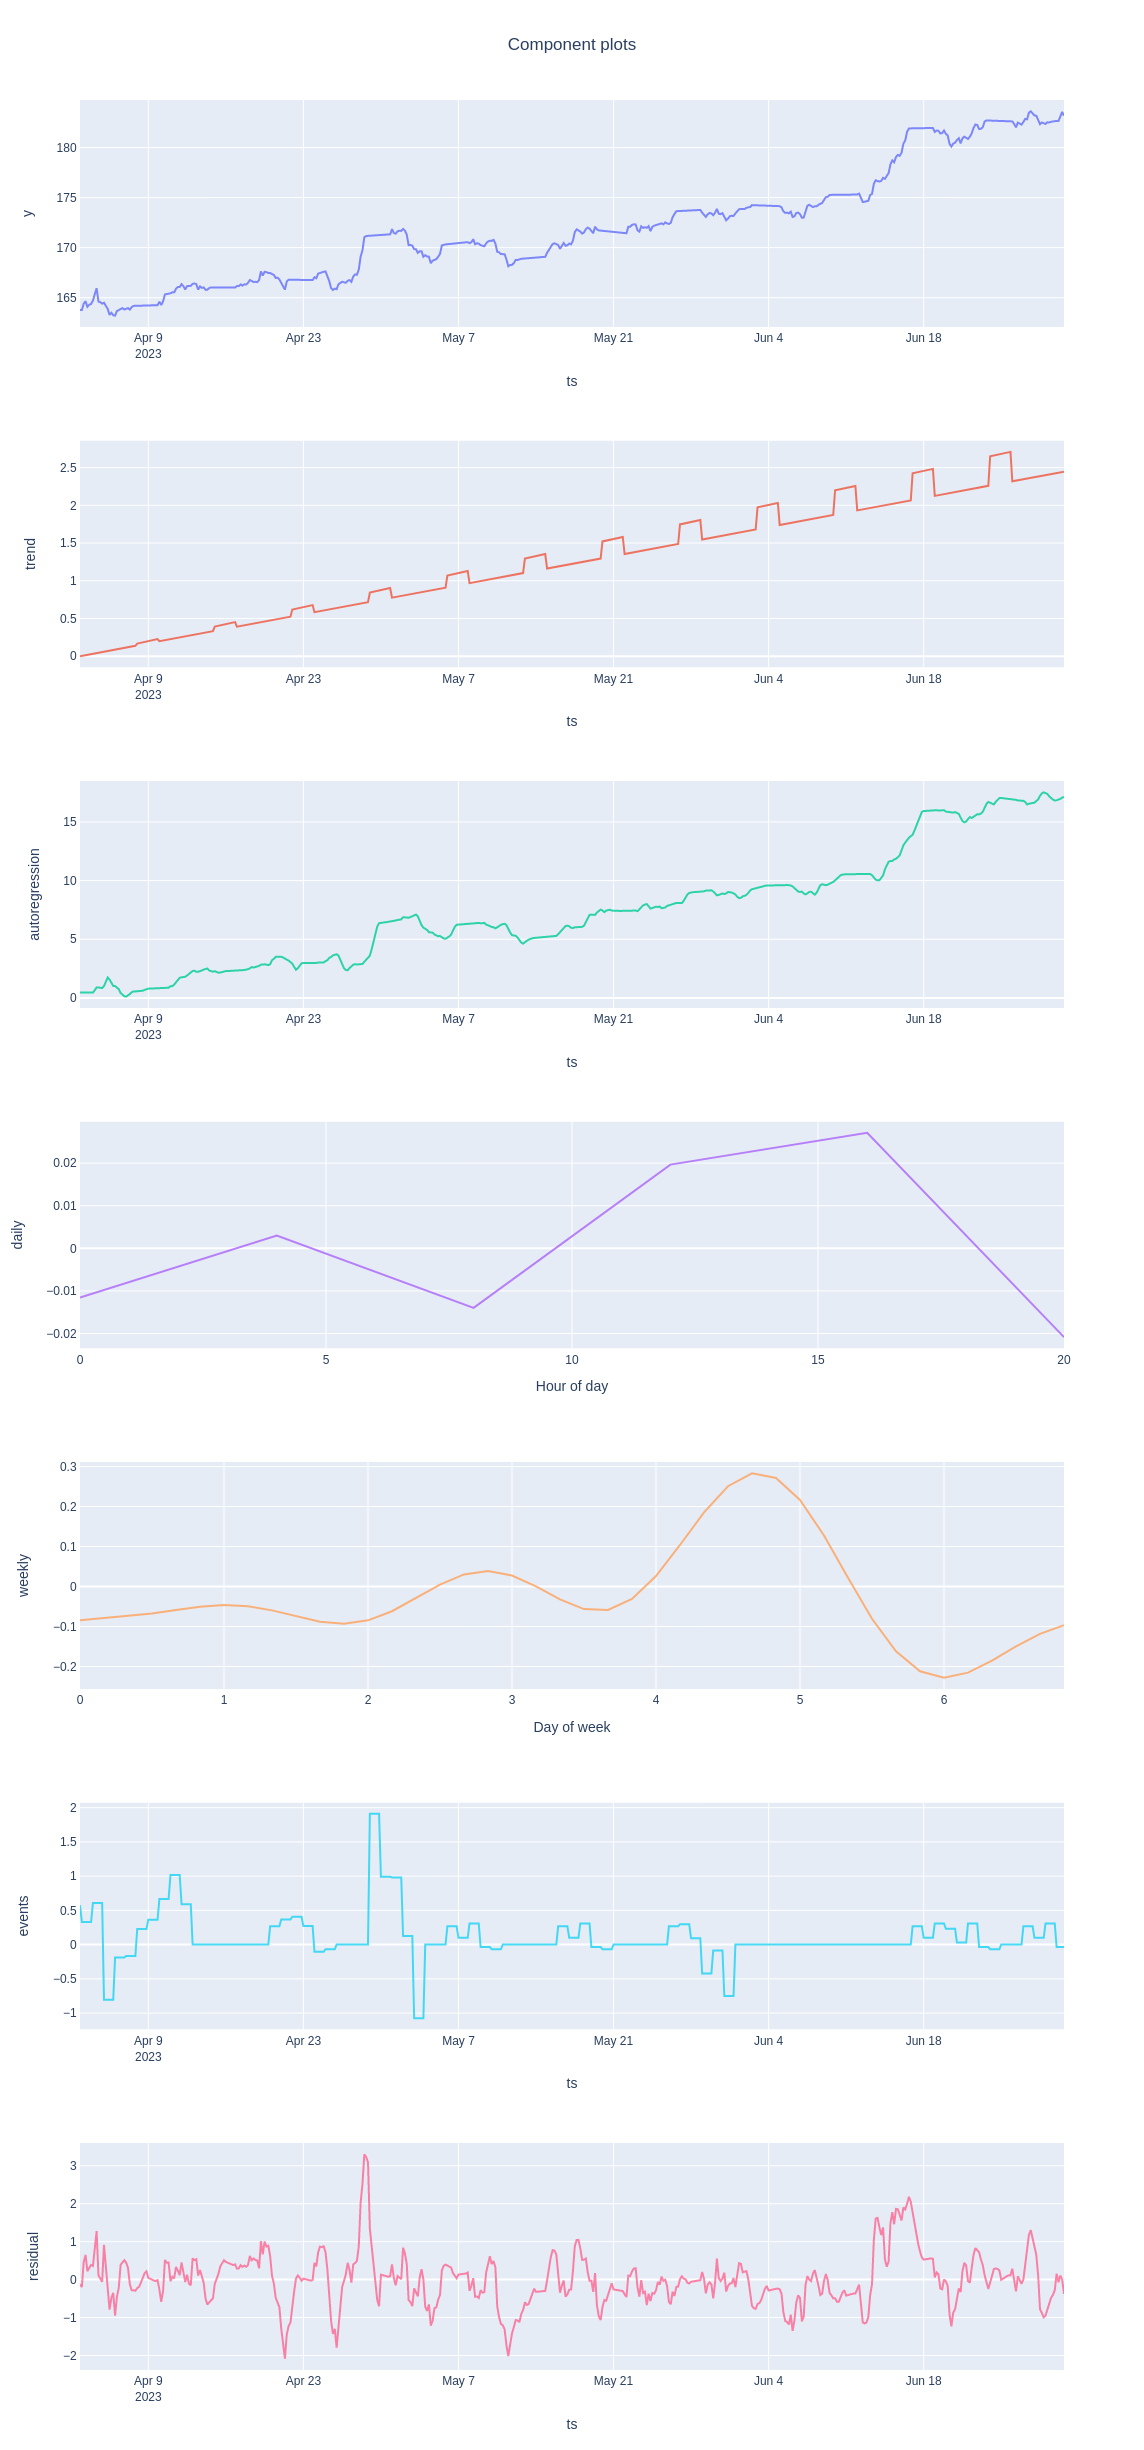

================================ Model Summary =================================

Number of observations: 534,   Number of features: 489
Method: Ridge regression
Number of nonzero features: 201
Regularization parameter: 0.6723

Residuals:
         Min           1Q       Median           3Q          Max
      -2.083      -0.3736     -0.01856       0.3438        3.302

            Pred_col   Estimate Std. Err Pr(>)_boot sig. code               95%CI
           Intercept      163.2    0.331     <2e-16       ***      (162.6, 163.9)
 events_C...New Year         0.       0.      1.000                      (0., 0.)
 events_C...w Year-1         0.       0.      1.000                      (0., 0.)
 events_C...w Year-2         0.       0.      1.000                      (0., 0.)
 events_C...w Year+1         0.       0.      1.000                      (0., 0.)
 events_C...w Year+2         0.       0.      1.000                      (0., 0.)
events_Christmas Day         0.       0.      1.000     

In [7]:

# Loads dataset into pandas DataFrame
# dl = DataLoader()
# df = dl.load_peyton_manning()

# specify dataset information
metadata = MetadataParam(
 time_col="<DTYYYYMMDD>_<TIME>",  # name of the time column ("date" in example above)
 value_col="<CLOSE>",  # name of the value column ("sessions" in example above)
# value_col="RSI",
 freq="4H"  # "H" for hourly, "D" for daily, "W" for weekly, etc.
           # Any format accepted by `pandas.date_range`
)

# df = df.loc['2022':'2023'].resample('D').max().dropna()

#df = df[['<DTYYYYMMDD>_<TIME>','<HIGH>']]
#df= df.iloc[:-30]

df_diff = df['<CLOSE>'].diff()
df_up, df_down = df_diff.copy(), df_diff.copy()
df_up[df_up < 0] = 0
df_down[df_down > 0] = 0
df_down = df_down * -1
#df['sim14_up'] = df_up.rolling(window=14).mean()
sim14_up= df_up.rolling(window=14).mean()
sim14_down = df_down.rolling(window=14).mean()
df['RSI'] = sim14_up / (sim14_up + sim14_down) * 100
#df.dropna()


forecaster = Forecaster()  # Creates forecasts and stores the result
result = forecaster.run_forecast_config(  # result is also stored as `forecaster.forecast_result`.
df=df,
config=ForecastConfig(
model_template=ModelTemplateEnum.SILVERKITE.name,
#model_template=ModelTemplateEnum.PROPHET.name,
#model_components_param=ModelComponentsParam(seasonality=dict(seasonality_mode='multiplicative')),
forecast_horizon=6,  # forecasts 365 steps ahead
 coverage=0.95,         # 95% prediction intervals
 metadata_param=metadata
)
)

ts = result.timeseries
fig = ts.plot()
plotly.io.show(fig)

	

grid_search = result.grid_search

cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=3,
     # The below saves space in the printed output. Remove to show all available metrics and columns.
     cv_report_metrics=None,
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
 # Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

	

backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

	

backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
     backtest_eval[metric].append(value)
     backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics
	

forecast = result.forecast
fig = forecast.plot()
fig.update_yaxes(dtick=0.)
plotly.io.show(fig)


forecast.df.head().round(2)

fig = forecast.plot_components()
plotly.io.show(fig)     # fig.show() if you are using "PROPHET" template
	

summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
print(summary)



In [3]:
 !pip freeze | grep holiday


holidays==0.24
holidays-ext==0.0.8


In [4]:
# df = pd.read_csv(
#     "GBPJPY.csv",
#     parse_dates=[['<DTYYYYMMDD>','<TIME>']]).set_index('<DTYYYYMMDD>_<TIME>'
#     )

In [5]:
# df.to_pickle('GBPJPY.pickle')

In [6]:
# backtest.df.to_pickle('greykite_predict_GBPJPY.pickle')

